# Example of an AutoBalanceBoost instance usage

Input data for AutoBalanceBoost includes imbalanced training sample and a separate array of class labels. Training sample should have an array-like table format with the (n_samples, n_features) dimensionality. The sample should contain numerical data with the number of features less than 100. The number of samples should be no less than 30 for each class. 

Creatinga synthetic dataset as an example.

In [15]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, Y = make_classification(n_classes=4, n_features=6, n_redundant=2, n_repeated=0, n_informative=4,
                           n_clusters_per_class=2, flip_y=0.05, n_samples=700, random_state=45,
                           weights=(0.7, 0.2, 0.05, 0.05))
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Fitting AutoBalanceBoost classifier.

In [25]:
from asid.automl_imbalanced.abb import AutoBalanceBoost
from datetime import datetime

t0 = datetime.now()
clf = AutoBalanceBoost()
clf.fit(X_train, y_train)
print("Fitting time: ", datetime.now() - t0)

Fitting time:  0:00:16.648517


Evaluating the quality of classification model. 

In [26]:
from sklearn.metrics import f1_score

pred = clf.predict(X_test)
print("AutoBalanceBoost F1-score for synthetic example: ", round(f1_score(y_test, pred, average="macro"), 2))

AutoBalanceBoost F1-score for synthetic example:  0.6


In addition to that, AutoBalanceBoost allows to calculate feature importances.

In [27]:
feat_imp = clf.feature_importances()
print("Feature importances: ", feat_imp)

Feature importances:  [0.1622119  0.17452391 0.18359398 0.17820891 0.14077694 0.16068436]


ASID also proposes an ImbalancedLearningClassifier estimator that searches for an optimal classifier for a given imbalanced task. It takes more time to evaluate, though allows to obtain a higher model quality. It searches through AutoBalanceBoost and combinations of SOTA ensemble algorithms and balancing procedures from imbalanced-learn library. 

# Example of an ImbalancedLearningClassifier instance usage

Input data for ImbalancedLearningClassifier includes imbalanced training sample and a separate array of class labels. Training sample should have an array-like table format with the (n_samples, n_features) dimensionality. The sample should contain numerical data with the number of features less than 100. The number of samples should be no less than 30 for each class. 

Fitting ImbalancedLearningClassifier classifier.

In [29]:
from asid.automl_imbalanced.ilc import ImbalancedLearningClassifier

clf = ImbalancedLearningClassifier(split_num=5, hyperopt_time=10)
clf.fit(X_train, y_train)

  0%|            | 11/9223372036854775807 [00:10<2434820743144301:13:36,  1.05trial/s, best loss: -0.44537206611215796]


  0%|            | 1/9223372036854775807 [00:10<25713205804120437:11:28, 10.04s/trial, best loss: -0.49800674333197853]
The best generative model is RandomOverSampler+catboost
Leader f1_macro score: 0.6643
Fitting time:  0:18:06.719862


As a result a combination of RandomOverSampler procedure and Catboost classifier was chosen and fitted. The optimal model label is stored in clf.classifer_label_, the score value is stored in clf.score_. The information about the models fitted during the ImbalancedLearningClassifier's run is stored in clf.evaluated_models_scores_ and clf.evaluated_models_time_.

Evaluating the quality of classification model on a test set. As can be seen, the out-of-fold accuracy for ImbalancedLearningClassifier is higher than for AutoBalanceBoost, though at a higher computational cost.

In [30]:
pred = clf.predict(X_test)
print("ImbalancedLearningClassifier F1-score for synthetic example: ", round(f1_score(y_test, pred, average="macro"), 2))

ImbalancedLearningClassifier F1-score for synthetic example:  0.63


Let's visualize the ImbalancedLearningClassifier's search and compare the alternatives.

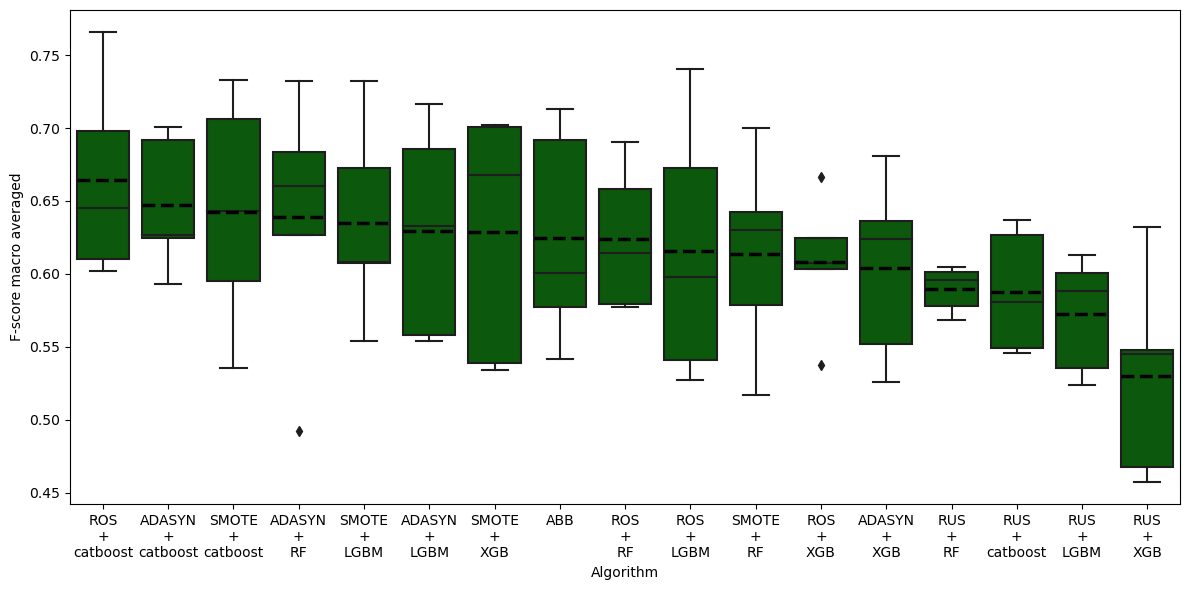

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def add_data(score, result_acc,alg_name):
    if alg_name.split("+")[0] =="RandomOverSampler":
        alg_name = "ROS"+"\n+\n"+alg_name.split("+")[1]
    elif alg_name.split("+")[0] =="RandomUnderSampler":
        alg_name = "RUS"+"\n+\n"+alg_name.split("+")[1]
    elif alg_name == "AutoBalanceBoost":
        alg_name="ABB"
    else:
        alg_name = alg_name.split("+")[0]+"\n+\n"+alg_name.split("+")[1]
    alg_name_list = [alg_name for el in range(len(score))]
    sub_result_acc = pd.DataFrame({"Algorithm":alg_name_list,"F-score macro averaged":score})
    if len(result_acc)==0:
        result_acc=sub_result_acc
    else:
        result_acc = pd.concat([result_acc, sub_result_acc], ignore_index=True, sort=False)
    return result_acc

result_acc = []
for meth in list(clf.evaluated_models_scores_.keys()):
    result_acc = add_data(clf.evaluated_models_scores_[meth],result_acc,meth)

result = result_acc
plt.figure(figsize=(12, 6))
metric = "F-score macro averaged"
result_group_sort = result.groupby("Algorithm")[metric].mean()
result_filter = result.loc[:,["Algorithm",metric]]
name_list = list(result_group_sort.sort_values(ascending=False).index)
sns.boxplot(x="Algorithm", y=metric, data=result_filter,showmeans=True,meanline=True,meanprops=dict(color='black', linewidth=2.5),order=name_list, color="darkgreen")
plt.tight_layout()
plt.show()

This plot demonstrates the alternatives that were fitted during the  ImbalancedLearningClassifier's run. As can be seen, a combination of Catboost and oversampling methods are the most efficient for the given dataset.